### Step 1 — Load + schema + basic health checks

In [5]:
import pandas as pd
from pathlib import Path

COMBINED = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/cleaned_datasets/all_cities_clean.parquet")
df = pd.read_parquet(COMBINED)

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

# quick null audit
nulls = df.isna().sum().sort_values(ascending=False)
print("\nNull counts:\n", nulls[nulls>0])

# unique values for keys
print("\nCities (n):", df["City"].nunique())
print("Building types (n):", df["Assumed_building_type"].nunique())

Shape: (6530761, 7)

Dtypes:
 City                          string[python]
Surface_area                         float64
Potential_installable_area           float64
Peak_installable_capacity            float64
Energy_potential_per_year            float64
Assumed_building_type                  Int64
Estimated_tilt                       float64
dtype: object

Null counts:
 Series([], dtype: int64)

Cities (n): 25
Building types (n): 10


### Step 2 — Coverage by city and by building type

In [9]:
# rows per city
city_counts = df["City"].value_counts().rename_axis("City").reset_index(name="rows")
display(city_counts.head(30)); print("TOTAL rows:", city_counts["rows"].sum())

# rows per building type 
bt_counts = df["Assumed_building_type"].value_counts(dropna=False).sort_index()
display(bt_counts.rename("rows").to_frame())

# heatmap-like pivot (counts): City × Building Type
pivot_counts = pd.pivot_table(df, index="City", columns="Assumed_building_type", values="Surface_area", aggfunc="count", fill_value=0)
pivot_counts.head(30)

,City,rows
0,LagosState,1329525
1,GreatDhakaRegion,632745
2,Mexico City,589629
3,DarEsSalaam,533855
4,SouthAfrica,414834
5,Manila,301381
6,Karachi,296688
7,Izmir,287695
8,Nairobi,272751
9,Accra,268947


TOTAL rows: 6530761


,rows
Assumed_building_type,
0,4151576
1,1544987
2,367820
3,8644
4,154164
5,150032
6,86643
7,35564
8,17537


Assumed_building_type,0,1,2,3,4,5,6,7,8,9
City,,,,,,,,,,
Accra,230102,2539,20564,0,3195,12547,0,0,0,0
Almaty,111650,8862,10146,0,6053,1628,0,0,0,0
Antigua,43031,133,2479,0,730,531,0,598,192,1210
Beirut,646,56168,6593,0,3171,3281,0,0,0,0
Colombo,226175,4965,15908,0,8448,12493,0,0,0,0
DarEsSalaam,499147,2056,10300,0,12687,9665,0,0,0,0
Dominica,34704,184,1365,0,454,323,0,267,170,374
GreatDhakaRegion,119767,429462,31709,8644,27540,15623,0,0,0,0
Grenada,46862,682,1492,0,392,455,0,523,108,601


### Step 3 — Domain sanity checks (no engineered features)

In [10]:
import numpy as np

checks = {}

# 3.1 Potential_installable_area should be ≤ Surface_area (allow NaNs)
bad_area = df[(df["Potential_installable_area"].notna()) &
              (df["Surface_area"].notna()) &
              (df["Potential_installable_area"] > df["Surface_area"])]

checks["area_ratio_violations"] = len(bad_area)

# 3.2 Non-negativity
nonneg_cols = ["Surface_area", "Potential_installable_area", "Peak_installable_capacity", "Energy_potential_per_year", "Estimated_tilt"]
for col in nonneg_cols:
    checks[f"negatives_in_{col}"] = int((df[col] < 0).sum(skipna=True))

# 3.3 Tilt within [0, 90]
tilt_out = df["Estimated_tilt"].dropna()
checks["tilt_out_of_range"] = int(((tilt_out < 0) | (tilt_out > 90)).sum())

# Report
checks

{'area_ratio_violations': 2,
 'negatives_in_Surface_area': 0,
 'negatives_in_Potential_installable_area': 0,
 'negatives_in_Peak_installable_capacity': 0,
 'negatives_in_Energy_potential_per_year': 0,
 'negatives_in_Estimated_tilt': 0,
 'tilt_out_of_range': 0}

In [11]:
df = df.drop(bad_area.index)
print("Dropped", len(bad_area), "rows with invalid area ratios.")

Dropped 2 rows with invalid area ratios.


In [12]:
df.shape

(6530759, 7)

### Step 4 — Univariate distributions (existing columns only, sampled for speed)

Sampled shape: (195524, 7)


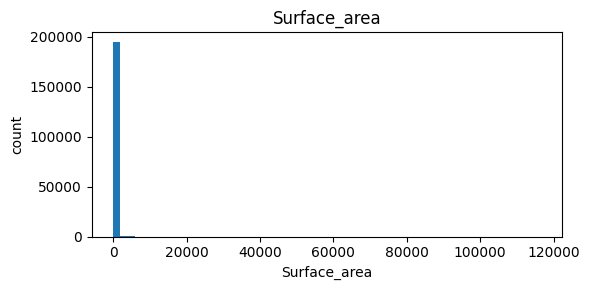

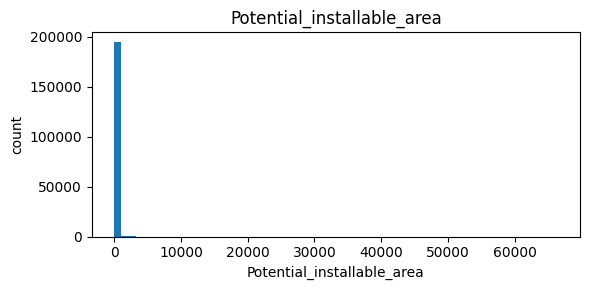

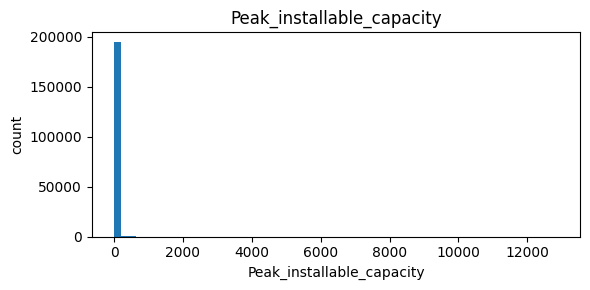

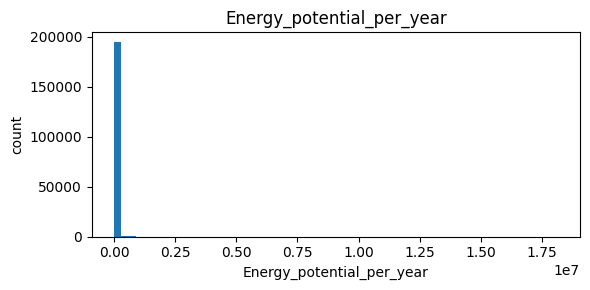

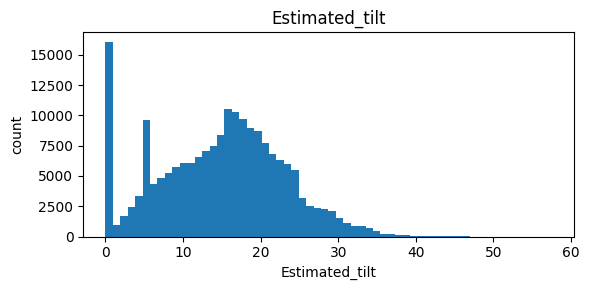

In [13]:
import numpy as np
import matplotlib.pyplot as plt

NUMERIC = ["Surface_area","Potential_installable_area","Peak_installable_capacity","Energy_potential_per_year","Estimated_tilt"]

# stratified-ish sample by city (cap ~200k total)
per_city = 8000
parts = []
for c, g in df.groupby("City", sort=False):
    parts.append(g.sample(min(len(g), per_city), random_state=42))
df_s = pd.concat(parts, ignore_index=True)

print("Sampled shape:", df_s.shape)

for col in NUMERIC:
    s = df_s[col].dropna()
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=60)
    plt.title(col)
    plt.xlabel(col); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

NUMERIC = ["Surface_area","Potential_installable_area","Peak_installable_capacity",
           "Energy_potential_per_year","Estimated_tilt"]

# 1) Zero share + robust quantiles
summary = []
for col in NUMERIC:
    s = df_s[col].dropna()
    zeros = int((s==0).sum())
    q = s.quantile([0.5, 0.9, 0.95, 0.99, 0.999])
    summary.append({
        "col": col,
        "n": int(s.size),
        "zeros": zeros,
        "zero_share": round(zeros/max(1,s.size), 4),
        "p50": q.loc[0.5],
        "p90": q.loc[0.9],
        "p95": q.loc[0.95],
        "p99": q.loc[0.99],
        "p999": q.loc[0.999],
        "max": s.max()
    })
pd.DataFrame(summary)

,col,n,zeros,zero_share,p50,p90,p95,p99,p999,max
0,Surface_area,195524,10,0.0001,102.220001,318.074000,452.158499,1040.845662,3779.004170,1.164841e+05
1,Potential_installable_area,195524,8091,0.0414,47.590000,196.200000,281.890012,653.134395,2640.226187,6.643088e+04
2,Peak_installable_capacity,195524,8091,0.0414,9.230000,38.070000,54.688499,126.623098,512.204067,1.288759e+04
3,Energy_potential_per_year,195524,8091,0.0414,12804.645000,51682.174719,74263.364125,176295.427187,732421.157925,1.814573e+07
4,Estimated_tilt,195524,15523,0.0794,15.480000,24.809999,28.219999,33.669998,39.554770,5.747000e+01


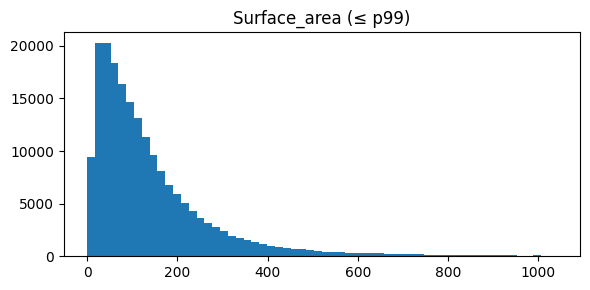

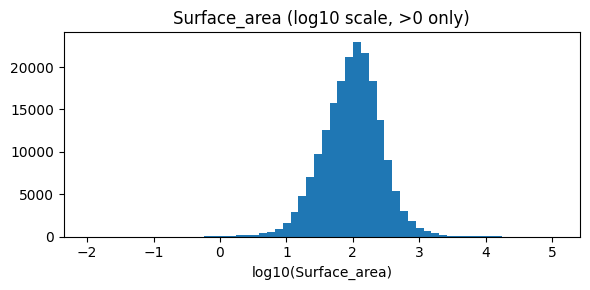

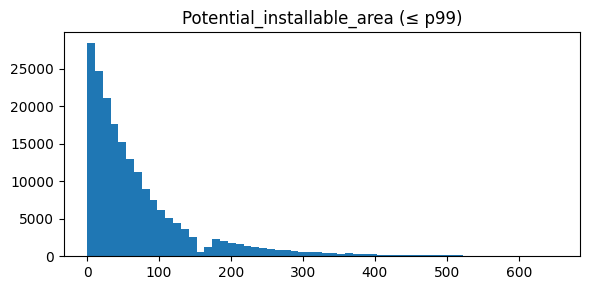

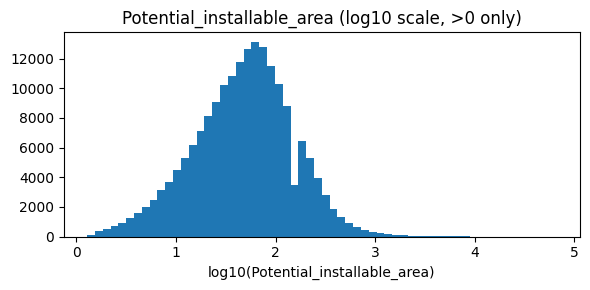

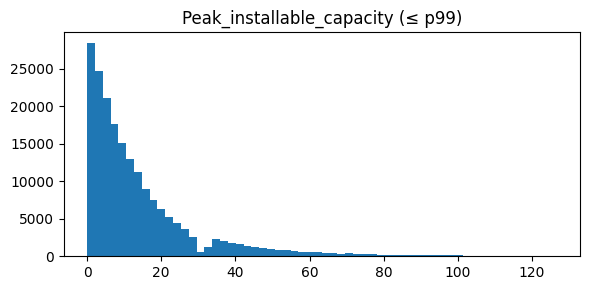

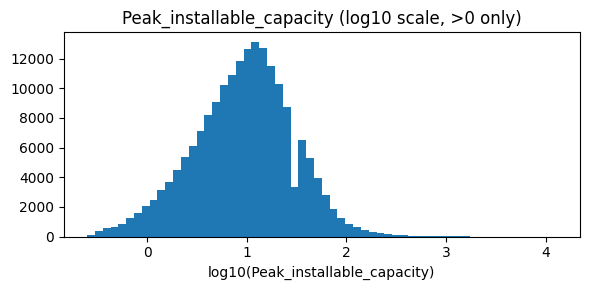

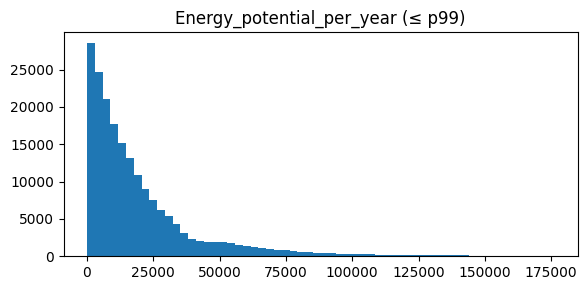

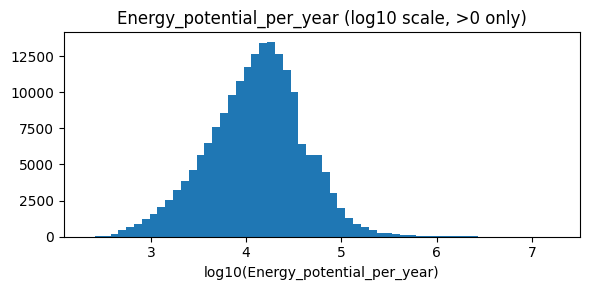

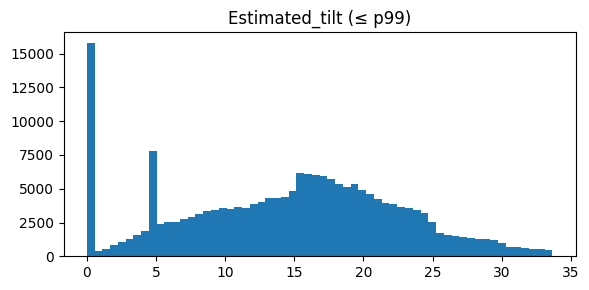

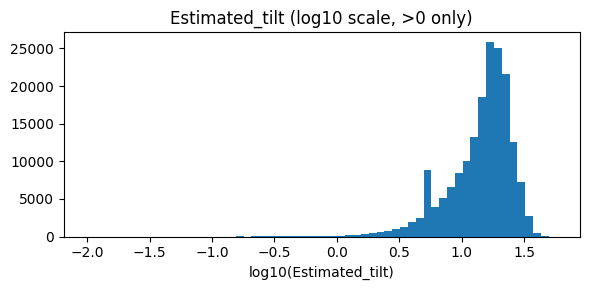

In [15]:
# 2) Re-plot (A) clipped at 99th percentile and (B) log-scale
for col in NUMERIC:
    s = df_s[col].dropna()

    # (A) Clip view at 99th percentile so the bulk is visible
    p99 = s.quantile(0.99)
    plt.figure(figsize=(6,3))
    plt.hist(s[s<=p99], bins=60)
    plt.title(f"{col} (≤ p99)")
    plt.tight_layout(); plt.show()

    # (B) Log-view to reveal the body + tail together (skip nonpositive)
    s_pos = s[s>0]
    if len(s_pos) > 0:
        plt.figure(figsize=(6,3))
        plt.hist(np.log10(s_pos), bins=60)
        plt.title(f"{col} (log10 scale, >0 only)")
        plt.xlabel(f"log10({col})"); plt.tight_layout(); plt.show()

### Step 5 — relationships

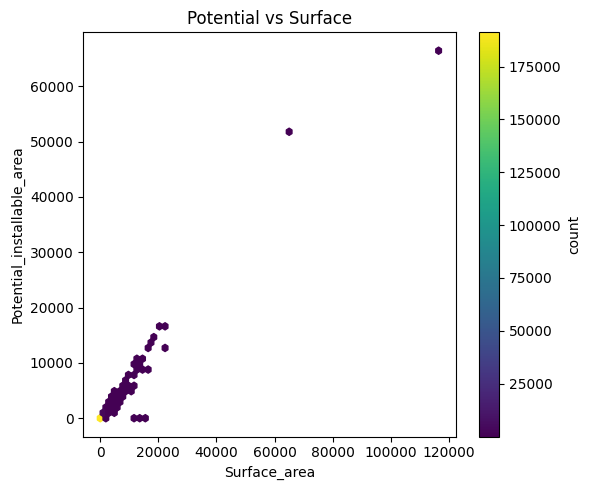

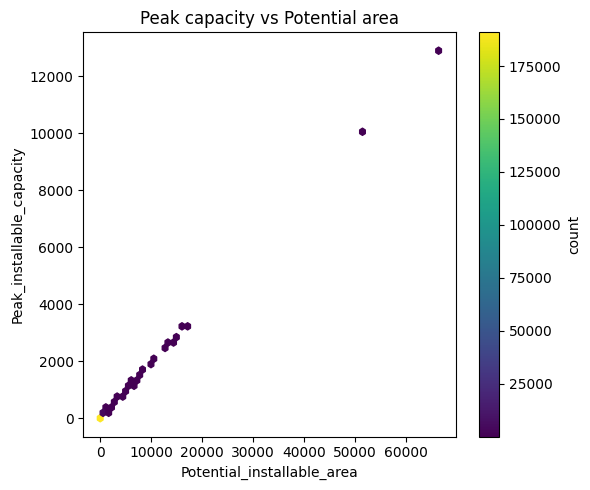

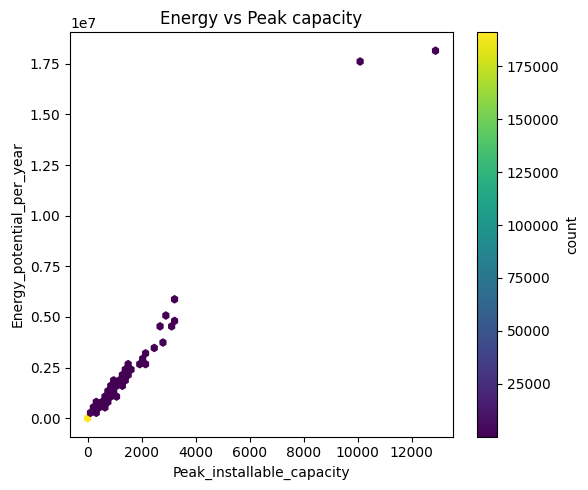

In [16]:
import matplotlib.pyplot as plt

# A) Potential_installable_area vs Surface_area
plt.figure(figsize=(6,5))
plt.hexbin(df_s["Surface_area"], df_s["Potential_installable_area"], gridsize=60, mincnt=1)
plt.xlabel("Surface_area"); plt.ylabel("Potential_installable_area"); plt.title("Potential vs Surface")
plt.colorbar(label="count"); plt.tight_layout(); plt.show()

# B) Peak_installable_capacity vs Potential_installable_area
plt.figure(figsize=(6,5))
plt.hexbin(df_s["Potential_installable_area"], df_s["Peak_installable_capacity"], gridsize=60, mincnt=1)
plt.xlabel("Potential_installable_area"); plt.ylabel("Peak_installable_capacity"); plt.title("Peak capacity vs Potential area")
plt.colorbar(label="count"); plt.tight_layout(); plt.show()

# C) Energy_potential_per_year vs Peak_installable_capacity
plt.figure(figsize=(6,5))
plt.hexbin(df_s["Peak_installable_capacity"], df_s["Energy_potential_per_year"], gridsize=60, mincnt=1)
plt.xlabel("Peak_installable_capacity"); plt.ylabel("Energy_potential_per_year"); plt.title("Energy vs Peak capacity")
plt.colorbar(label="count"); plt.tight_layout(); plt.show()

Potential vs Surface: tight, near-linear band from the origin → potential area scales with roof size (good). A few huge roofs pull the axes—likely legit large sites.

Peak capacity vs Potential area: again ~linear → implies an almost constant W/m² across records (expected for PV density).

Energy per year vs Peak capacity: roughly linear with some spread → different climates/tilts/shading → capacity-factor differences. Still coherent.

### Step 6 — group comparisons

<Figure size 5000x600 with 0 Axes>

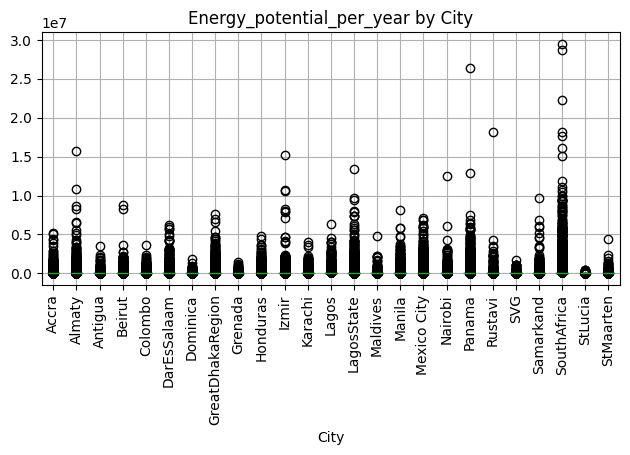

<Figure size 600x300 with 0 Axes>

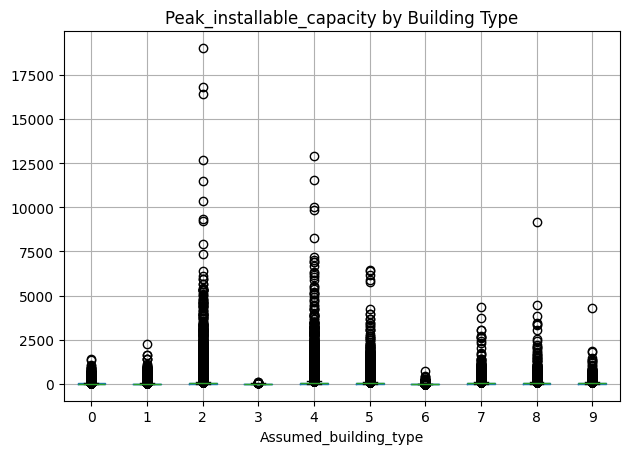

In [22]:
import matplotlib.pyplot as plt

# (recompute if you restarted)
city_counts = df["City"].value_counts().rename_axis("City").reset_index(name="rows")

# Boxplots by city (Energy_potential_per_year)
cities = city_counts.head(30)["City"].tolist()
subset = df[df["City"].isin(cities)][["City","Energy_potential_per_year"]].dropna()

plt.figure(figsize=(50,6))
subset.boxplot(by="City", column="Energy_potential_per_year", rot=90)
plt.suptitle("")
plt.title("Energy_potential_per_year by City")
plt.tight_layout(); plt.show()

# Boxplots by building type (Peak_installable_capacity)
plt.figure(figsize=(6,3))
df[["Assumed_building_type","Peak_installable_capacity"]].dropna().boxplot(
    by="Assumed_building_type", column="Peak_installable_capacity"
)
plt.suptitle("")
plt.title("Peak_installable_capacity by Building Type")
plt.tight_layout(); plt.show()

### Step 7 — Report

In [25]:
import json, numpy as np
from pathlib import Path

def to_builtin(o):
    if isinstance(o, np.generic):
        return o.item()
    if isinstance(o, dict):
        return {to_builtin(k): to_builtin(v) for k, v in o.items()}
    if isinstance(o, (list, tuple, set)):
        return [to_builtin(x) for x in o]
    return o

# if you still have report from above:
out_path = Path("data_quality_report.json")
clean_report = to_builtin(report)
out_path.write_text(json.dumps(clean_report, indent=2))
print(f"wrote {out_path.as_posix()}")

wrote data_quality_report.json


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUMERIC = ["Surface_area","Potential_installable_area","Peak_installable_capacity",
           "Energy_potential_per_year","Estimated_tilt"]

# for huge data we use df_s made in Step 4; fall back to df if needed
X = df_s if "df_s" in globals() else df
X = X[NUMERIC + ["City","Assumed_building_type"]].copy()


**Robust univariate outliers (IQR + MAD)**

IQR rule: values outside [Q1−k·IQR, Q3+k·IQR], default k=1.5 (use 3.0 to be gentler).

MAD-z rule: |x−median| / (1.4826*MAD) > c, default c=3.5 (very robust).

For strictly-positive columns we also check log10 space to handle heavy right tails.

In [28]:
def iqr_mask(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return (s < lo) | (s > hi)

def mad_mask(s, c=3.5):
    med = s.median()
    mad = (s - med).abs().median()
    if mad == 0 or np.isnan(mad):
        return pd.Series(False, index=s.index)
    z = (s - med).abs() / (1.4826 * mad)
    return z > c

def positive_log_mask(s, rule="iqr", k=1.5, c=3.5):
    # only consider strictly positive values for log check
    mpos = s > 0
    s_pos = np.log10(s[mpos])
    if rule == "iqr":
        mask = iqr_mask(s_pos, k=k)
    else:
        mask = mad_mask(s_pos, c=c)
    out = pd.Series(False, index=s.index)
    out.loc[mpos] = mask.values
    return out

positive_cols = ["Surface_area","Potential_installable_area","Peak_installable_capacity","Energy_potential_per_year"]
tilt_col = "Estimated_tilt"

uni_out = {}

for col in NUMERIC:
    s = X[col].dropna()
    m_iqr = iqr_mask(s, k=1.5)
    m_mad = mad_mask(s, c=3.5)

    # add log check for positive cols
    if col in positive_cols:
        m_log = positive_log_mask(s, rule="iqr", k=1.5)
        m_log_mad = positive_log_mask(s, rule="mad", c=3.5)
    else:
        m_log = pd.Series(False, index=s.index)
        m_log_mad = pd.Series(False, index=s.index)

    uni_out[col] = {
        "n": int(s.size),
        "iqr_outliers": int(m_iqr.sum()),
        "mad_outliers": int(m_mad.sum()),
        "log_iqr_outliers": int(m_log.sum()),
        "log_mad_outliers": int(m_log_mad.sum()),
        "p99": float(s.quantile(0.99)),
        "p999": float(s.quantile(0.999)),
        "max": float(s.max())
    }

pd.DataFrame(uni_out).T.sort_index()


,n,iqr_outliers,mad_outliers,log_iqr_outliers,log_mad_outliers,p99,p999,max
Energy_potential_per_year,195524.0,16485.0,15573.0,2428.0,271.0,176295.427187,732421.157925,1.814573e+07
Estimated_tilt,195524.0,390.0,34.0,0.0,0.0,33.669998,39.554770,5.747000e+01
Peak_installable_capacity,195524.0,17110.0,16051.0,2435.0,246.0,126.623098,512.204067,1.288759e+04
Potential_installable_area,195524.0,17109.0,16053.0,2444.0,248.0,653.134395,2640.226187,6.643088e+04
Surface_area,195524.0,13057.0,11567.0,3359.0,1135.0,1040.845662,3779.004170,1.164841e+05


**Group-wise outliers (by City and by Building Type)**

This checks whether some values are outliers within their city/type (fairer when cities differ in scale).

In [29]:
def group_outlier_counts(frame, group_col, val_col, rule="iqr", k=1.5, c=3.5, log_for_positive=True):
    rows = []
    pos = val_col in positive_cols
    for g, sub in frame[[group_col, val_col]].dropna().groupby(group_col, sort=False):
        s = sub[val_col]
        masks = []

        if rule == "iqr":
            masks.append(iqr_mask(s, k=k))
            if log_for_positive and pos:
                masks.append(positive_log_mask(s, rule="iqr", k=k))
        else:
            masks.append(mad_mask(s, c=c))
            if log_for_positive and pos:
                masks.append(positive_log_mask(s, rule="mad", c=c))

        m = masks[0]
        for mm in masks[1:]:
            m = m | mm

        rows.append({"group": g, "n": int(s.size), "outliers": int(m.sum()),
                     "share": float(m.mean())})
    out = pd.DataFrame(rows).sort_values("share", ascending=False)
    return out

# Example: by City for Energy, and by Building type for Peak capacity
city_energy = group_outlier_counts(X, "City", "Energy_potential_per_year", rule="iqr", k=1.5)
bt_peak     = group_outlier_counts(X, "Assumed_building_type", "Peak_installable_capacity", rule="iqr", k=1.5)

city_energy.head(15), bt_peak


(               group     n  outliers     share
 9              Izmir  8000      1261  0.157625
 19           Rustavi  8000      1069  0.133625
 1             Almaty  8000      1066  0.133250
 15            Manila  8000       833  0.104125
 17           Nairobi  8000       785  0.098125
 3             Beirut  8000       759  0.094875
 11           Karachi  8000       746  0.093250
 20         Samarkand  8000       718  0.089750
 6   GreatDhakaRegion  8000       710  0.088750
 18            Panama  8000       692  0.086500
 2            Antigua  8000       688  0.086000
 21          Honduras  8000       654  0.081750
 14          Maldives  8000       641  0.080125
 4            Colombo  8000       633  0.079125
 22         StMaarten  8000       630  0.078750,
    group       n  outliers     share
 5      9    1099       126  0.114650
 3      4    5125       528  0.103024
 4      1   35741      3305  0.092471
 2      2   12098      1115  0.092164
 7      8     560        51  0.091071
 0 

In [30]:
def show_top_extremes(df_full, column, n=12):
    s = df_full[column].dropna()
    top_idx = s.nlargest(n).index
    cols = ["City","Assumed_building_type", column]
    display(df_full.loc[top_idx, cols])

for col in NUMERIC:
    print(f"\nTop extremes for {col}:")
    show_top_extremes(df, col, n=12)  # use full df here to see true top rows



Top extremes for Surface_area:


,City,Assumed_building_type,Surface_area
5974516,Panama,2,128651.800000
6045716,Rustavi,4,116484.117188
2348346,SouthAfrica,2,114070.650000
2567912,SouthAfrica,2,110209.300000
2126119,Izmir,2,83548.390000
2372401,SouthAfrica,2,83503.020000
335229,Almaty,4,75663.260000
2725598,SouthAfrica,2,65931.290000
2385170,SouthAfrica,4,65428.500000
5976927,Panama,2,64291.860000



Top extremes for Potential_installable_area:


,City,Assumed_building_type,Potential_installable_area
5974516,Panama,2,98014.200000
2567912,SouthAfrica,2,86609.040000
2348346,SouthAfrica,2,84615.000000
6045716,Rustavi,4,66430.882812
2372401,SouthAfrica,2,65453.630000
2126119,Izmir,2,59335.890000
335229,Almaty,4,59245.570000
2725598,SouthAfrica,2,53294.350000
2385170,SouthAfrica,4,51553.310000
3195567,LagosState,4,50623.128906



Top extremes for Peak_installable_capacity:


,City,Assumed_building_type,Peak_installable_capacity
5974516,Panama,2,19014.750000
2567912,SouthAfrica,2,16785.350000
2348346,SouthAfrica,2,16415.310000
6045716,Rustavi,4,12887.589844
2372401,SouthAfrica,2,12698.010000
335229,Almaty,4,11516.630000
2126119,Izmir,2,11511.160000
2725598,SouthAfrica,2,10349.440000
2385170,SouthAfrica,4,10011.340000
3195567,LagosState,4,9840.530273



Top extremes for Energy_potential_per_year:


,City,Assumed_building_type,Energy_potential_per_year
2567912,SouthAfrica,2,29525434.0
2348346,SouthAfrica,2,28776038.0
5974516,Panama,2,26430508.0
2372401,SouthAfrica,2,22335790.0
2725598,SouthAfrica,2,18183972.0
6045716,Rustavi,4,18145726.0
2385170,SouthAfrica,4,17670022.0
2350628,SouthAfrica,2,16170067.0
335229,Almaty,4,15731714.0
2126119,Izmir,2,15154422.0



Top extremes for Estimated_tilt:


,City,Assumed_building_type,Estimated_tilt
368179,Almaty,0,57.47
316511,Almaty,1,56.31
6116961,Samarkand,0,54.42
344483,Almaty,0,54.27
6168208,Samarkand,0,54.20
6194048,Samarkand,0,54.01
6054912,Samarkand,0,53.71
304415,Almaty,0,53.47
348511,Almaty,0,53.37
6111909,Samarkand,0,53.27


<Figure size 1000x400 with 0 Axes>

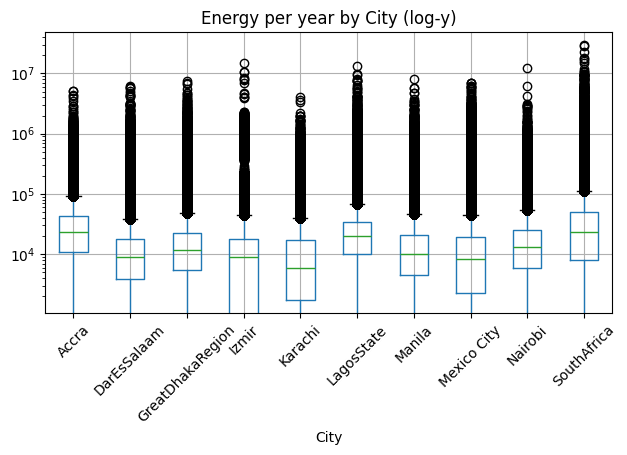

<Figure size 700x300 with 0 Axes>

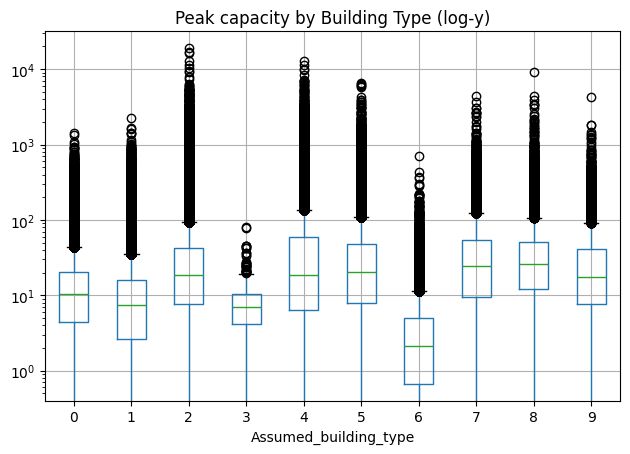

In [31]:
# City vs Energy on log-y
sub = df[df["City"].isin(df["City"].value_counts().head(10).index)]
plt.figure(figsize=(10,4))
sub.boxplot(by="City", column="Energy_potential_per_year", rot=45)
plt.yscale("log"); plt.suptitle(""); plt.title("Energy per year by City (log-y)")
plt.tight_layout(); plt.show()

# Building type vs Peak capacity on log-y
plt.figure(figsize=(7,3))
df[["Assumed_building_type","Peak_installable_capacity"]].dropna().boxplot(
    by="Assumed_building_type", column="Peak_installable_capacity")
plt.yscale("log"); plt.suptitle(""); plt.title("Peak capacity by Building Type (log-y)")
plt.tight_layout(); plt.show()
